In [8]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 0) Paths
MATRIX_HIGH_VAR = "data/processed/country_index_matrix_HIGH_VARIANCE.csv"
MATRIX_MEDIAN   = "data/processed/country_index_matrix_median.csv"

OUT_DIR = "data/processed/clustering"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load matrix
if os.path.exists(MATRIX_HIGH_VAR):
    df = pd.read_csv(MATRIX_HIGH_VAR)
    print("Loaded:", MATRIX_HIGH_VAR)
elif os.path.exists(MATRIX_MEDIAN):
    df = pd.read_csv(MATRIX_MEDIAN)
    print("Loaded:", MATRIX_MEDIAN)
else:
    raise FileNotFoundError(
        "Could not find a country index matrix. "
        "Run index_generation.ipynb first to create:\n"
        f"- {MATRIX_MEDIAN}\n- {MATRIX_HIGH_VAR}"
    )

# Drop obvious non-feature columns if they exist
META = {"Country", "date", "year", "window", "window_id"}
drop_cols = [c for c in ["date"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

assert "Country" in df.columns, "Your matrix must have a 'Country' column."

# Build feature list (exclude common meta columns)
feature_cols = [c for c in df.columns if c not in META]

# One row per Country (country-level clustering)
if df["Country"].duplicated().any():
    df = (
        df.groupby("Country")[feature_cols]
            .median()
            .reset_index()
    )
    print("Collapsed to country-level matrix:", df.shape)
else:
    print("Already country-level:", df.shape)

feature_cols = [c for c in df.columns if c != "Country"]

# Build X (numeric only) + missing handling
X_raw = df[feature_cols].apply(pd.to_numeric, errors="coerce")
X = X_raw.fillna(X_raw.median(numeric_only=True))

print("Matrix shape:", X.shape, "(countries x features)")
print("Feature count:", len(feature_cols))
print("Unique countries:", df["Country"].nunique(), "Rows:", len(df))


Loaded: data/processed/country_index_matrix_HIGH_VARIANCE.csv
Collapsed to country-level matrix: (70, 25)
Matrix shape: (70, 24) (countries x features)
Feature count: 24
Unique countries: 70 Rows: 70


In [9]:

# 2) Scale 
USE_ROBUST = False  # set True if you suspect strong outliers
scaler = RobustScaler() if USE_ROBUST else StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Optional PCA
USE_PCA = True
PCA_N_COMPONENTS = 0.90  # keep 90% variance

if USE_PCA:
    pca = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
    X_model = pca.fit_transform(X_scaled)
    explained = float(np.sum(pca.explained_variance_ratio_))
    print("PCA shape:", X_model.shape)
    print(f"PCA explained variance: {explained:.3f}")
else:
    X_model = X_scaled
    pca = None



PCA shape: (70, 15)
PCA explained variance: 0.906


In [10]:
# 4) Pick k using Silhouette (+ extra metrics)
def evaluate_k_range(Xm, k_min=2, k_max=12, random_state=42):
    rows = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=25, random_state=random_state)
        labels = km.fit_predict(Xm)

        sil = silhouette_score(Xm, labels)
        ch  = calinski_harabasz_score(Xm, labels)
        db  = davies_bouldin_score(Xm, labels)

        rows.append({
            "k": k,
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": db
        })
    return pd.DataFrame(rows).sort_values("silhouette", ascending=False)

k_report = evaluate_k_range(X_model, k_min=2, k_max=12)
display(k_report)

best_k = int(k_report.iloc[0]["k"])
print("Best k by silhouette:", best_k)

k_report.to_csv(os.path.join(OUT_DIR, "k_report.csv"), index=False)

# 5) Fit final KMeans
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels_km = kmeans.fit_predict(X_model)

df_out = df[["Country"]].copy()
df_out["cluster_kmeans"] = labels_km

df_out.to_csv(os.path.join(OUT_DIR, "country_clusters_kmeans.csv"), index=False)
display(df_out.head())



,k,silhouette,calinski_harabasz,davies_bouldin
3,5,0.182491,10.255929,1.531957
0,2,0.179582,14.689337,2.026750
2,4,0.171080,11.425875,1.684764
1,3,0.171009,12.439774,1.827273
5,7,0.163268,9.503109,1.494186
6,8,0.160911,9.790769,1.317415
4,6,0.155134,9.971507,1.544848
7,9,0.154140,9.144214,1.234623
10,12,0.139930,8.776975,1.257661
9,11,0.139821,9.150866,1.276085


Best k by silhouette: 5


,Country,cluster_kmeans
0,AE,1
1,AR,3
2,AT,2
3,AU,0
4,BD,4


In [11]:
# 6) Hierarchical clustering
RUN_HIERARCHICAL = True
if RUN_HIERARCHICAL:
    agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    labels_ag = agg.fit_predict(X_model)
    df_out["cluster_agglo"] = labels_ag
    df_out.to_csv(os.path.join(OUT_DIR, "country_clusters_kmeans_plus_agglo.csv"), index=False)



In [12]:
# 7) Interpretation: what defines each cluster?
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
X_scaled_df["Country"] = df["Country"].values
X_scaled_df["cluster"] = labels_km

cluster_profiles = X_scaled_df.groupby("cluster")[feature_cols].mean()

TOP_N = 8
summary_rows = []
for cl in cluster_profiles.index:
    s = cluster_profiles.loc[cl].sort_values(ascending=False)
    top_pos = s.head(TOP_N)
    top_neg = s.tail(TOP_N)

    summary_rows.append({
        "cluster": cl,
        "top_positive_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_pos.items()]),
        "top_negative_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_neg.items()]),
        "n_countries": int((labels_km == cl).sum())
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values("cluster")
display(cluster_summary)

cluster_profiles.to_csv(os.path.join(OUT_DIR, "cluster_profiles_zscores.csv"))
cluster_summary.to_csv(os.path.join(OUT_DIR, "cluster_summary_top_features.csv"), index=False)

countries_per_cluster = (
    df_out.groupby("cluster_kmeans")["Country"]
    .apply(list)
    .reset_index(name="countries")
)
display(countries_per_cluster)
countries_per_cluster.to_json(
    os.path.join(OUT_DIR, "countries_per_cluster.json"),
    orient="records",
    indent=2
)


,cluster,top_positive_features,top_negative_features,n_countries
0,0,"health_sleep_crisis_index (3.38), crime_cyberc...","finance_macro_pressure_index (0.40), sports_el...",4
1,1,"finance_crypto_speculation_index (0.06), enter...","social_dating_culture_index (-0.45), luxury_el...",29
2,2,"luxury_elite_mobility_index (2.12), luxury_sta...","health_sleep_crisis_index (-0.20), social_migr...",8
3,3,"environment_energy_transition_index (1.04), en...","luxury_status_consumption_index (0.03), crime_...",19
4,4,"environment_pollution_index (1.66), crime_orga...","luxury_status_consumption_index (-0.28), luxur...",10


,cluster_kmeans,countries
0,0,"[AU, CA, GB, US]"
1,1,"[AE, BG, BO, CZ, EC, EE, EG, GH, GR, HR, HU, I..."
2,2,"[AT, BE, CH, DE, ES, FR, NL, PL]"
3,3,"[AR, BR, CL, CO, DK, FI, HK, IE, JP, KR, MX, N..."
4,4,"[BD, ID, IN, KE, MY, NG, PE, PH, PK, VN]"


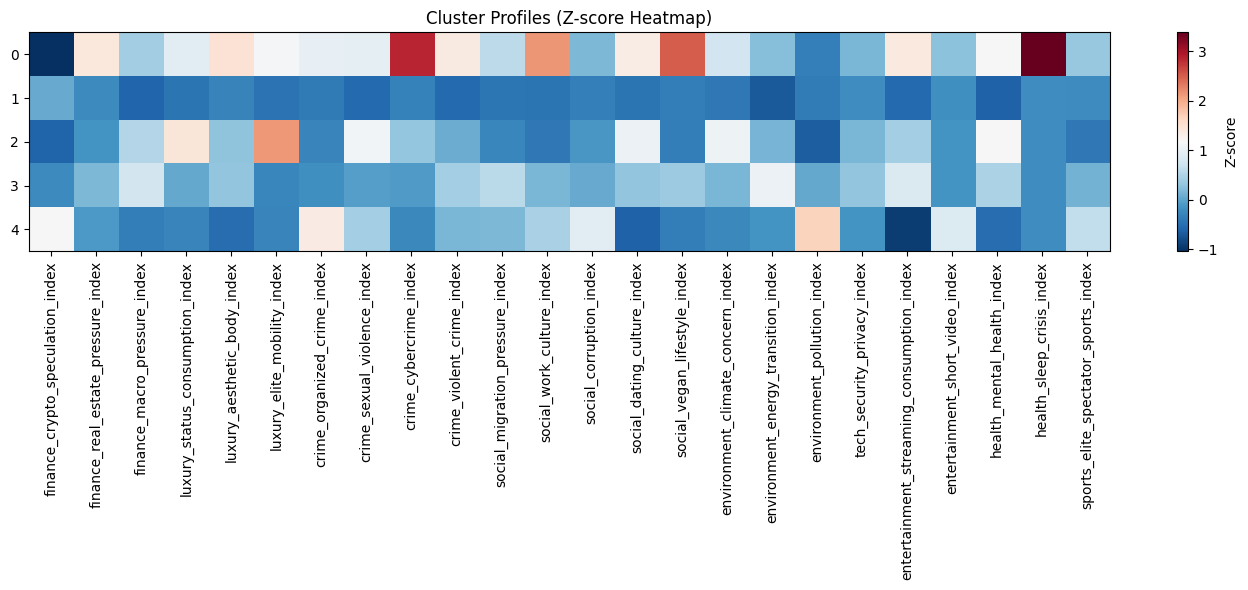

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

profiles = pd.read_csv("data/processed/clustering/cluster_profiles_zscores.csv", index_col=0)

plt.figure(figsize=(14,6))
plt.imshow(profiles, aspect="auto",cmap="RdBu_r")
plt.colorbar(label="Z-score")
plt.xticks(range(len(profiles.columns)), profiles.columns, rotation=90)
plt.yticks(range(len(profiles.index)), profiles.index)
plt.title("Cluster Profiles (Z-score Heatmap)")
plt.tight_layout()
plt.show()


kırmızı → pozitif z
→ “Bu cluster bu index’te ortalamanın üstünde”
mavi  → negatif z
→ “Bu cluster bu index’te ortalamanın altında”

beyaz → “Bu index bu cluster için ayırt edici değil”

Küme 0 (Batı/Anglosakson Grubu): AU, CA, GB, US gibi ülkelerden oluşuyor. Bu küme özellikle crime_cybercrime_index ve health_sleep_crisis_index alanlarında aşırı yüksek (koyu kırmızı) bir Z-score'a sahip. Bu, modelin bu ülkelerin dijitalleşme ve yaşam tarzı sorunlarını başarıyla ayırt ettiğini gösterir.

Küme 4 (Gelişmekte Olan Büyük Ekonomiler): IN, ID, PK, VN gibi ülkeler. environment_pollution_index (çevre kirliliği) kısmındaki turuncu/kırmızı tonlar, bu kümenin karakteristiğini yansıtıyor.

Küme 1 ve 3'teki Benzerlik: Bu iki küme haritada birbirine oldukça yakın (çoğunlukla mavi tonlarda) görünüyor. Bu durum, bu ülkelerin birçok endekste "dünya ortalamasının biraz altında" veya "stabil" olduğunu gösteriyor.

<Axes: >

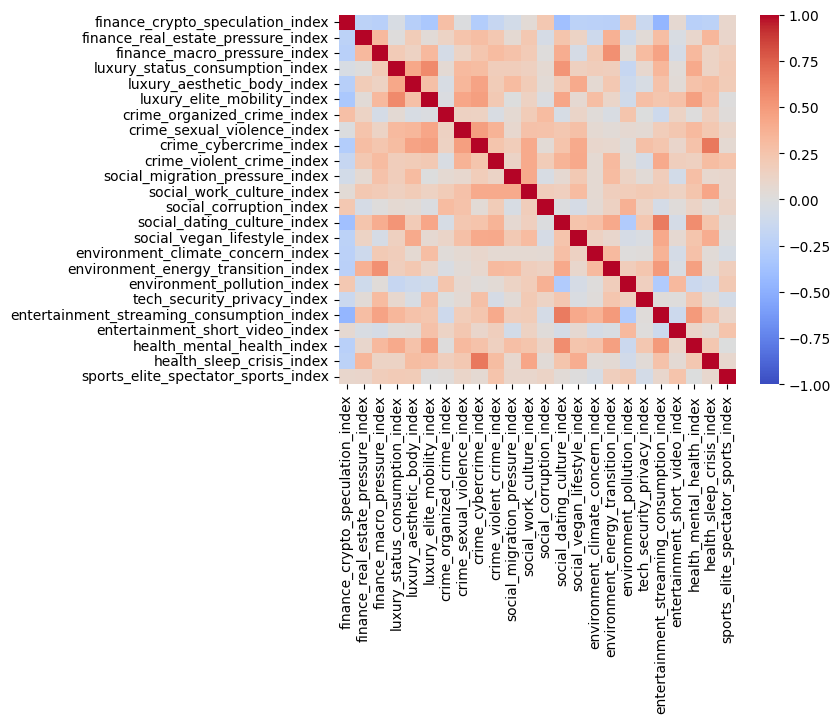

In [14]:
# Correlation matrix kontrol
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='coolwarm')
# Eğer 0.8+ korelasyon varsa feature'ları merge et